Load Modules

In [6]:
from easymore.easymore import easymore
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from pathlib import Path
from shutil import copyfile
from datetime import datetime
import networkx as nx
from typing import (
    Union,
)

## Control file handling

In [7]:
# Easy access to control file folder
controlFolder = Path('../0_control_files')
 
# Store the name of the 'active' file in a variable
controlFile = 'control_active.txt'
 
#Function to extract a given setting from the control file
def read_from_control( file, setting ):
     
    # Open 'control_active.txt' and ...
    with open(file) as contents:
        for line in contents:
             
            # ... find the line with the requested setting
            if setting in line and not line.startswith('#'):
                break
     
    # Extract the setting's value
    substring = line.split('|',1)[1]      # Remove the setting's name (split into 2 based on '|', keep only 2nd part)
    substring = substring.split('#',1)[0] # Remove comments, does nothing if no '#' is found
    substring = substring.strip()         # Remove leading and trailing whitespace, tabs, newlines
        
    # Return this value   
    return substring
 
#Function to specify a default path
def make_default_path(suffix):
     
    # Get the root path
    rootPath = Path( read_from_control(controlFolder/controlFile,'root_path') )
     
    # Get the domain folder
    #domain_name = read_from_control(controlFolder/controlFile,'domain_name')
    #domainFolder = 'domain_' + domain_name
     
    # Specify the forcing path
    defaultPath = rootPath / suffix
     
    return defaultPath

# Get the domain folder
domain_name = read_from_control(controlFolder/controlFile,'domain_name')
domainFolder = 'domain_' + domain_name

#%% assigning input files
# Note : this is an example for the Fraser setup
input_basin_path = read_from_control(controlFolder/controlFile,'input_basin_path')
input_basin_name = read_from_control(controlFolder/controlFile,'input_basin_name')
#input_basin = '../cat_pfaf_78_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'
input_river_path = read_from_control(controlFolder/controlFile,'input_river_path')
input_river_name = read_from_control(controlFolder/controlFile,'input_river_name')
#input_river = '../rivEndoMERITpfaf_78.shp'
 
outdir_basin = read_from_control(controlFolder/controlFile,'subset_basin_outdir')
outdir_river = read_from_control(controlFolder/controlFile,'subset_river_outdir')

# Specify default path if needed
if input_basin_path == 'default':
    input_basin_path = make_default_path('shapefiles/catchment/') # outputs a Path()
else:
    input_basin_path = Path(input_basin_path) # make sure a user-specified path is a Path()
    
if input_river_path == 'default':
    input_river_path = make_default_path('shapefiles/river_network/') # outputs a Path()
else:
    input_river_path = Path(input_river_path) # make sure a user-specified path is a Path()
    
if outdir_basin == 'default':
    outdir_basin = make_default_path('shapefiles/catchment/') # outputs a Path()
else:
    outdir_basin = Path(outdir_basin) # make sure a user-specified path is a Path()
 
if outdir_river == 'default':
    outdir_river = make_default_path('shapefiles/river_network/') # outputs a Path()
else:
    outdir_river = Path(outdir_river) # make sure a user-specified path is a Path()

# Get additional settings
hruid = read_from_control(controlFolder/controlFile,'river_basin_shp_rm_hruid')
segid = read_from_control(controlFolder/controlFile,'river_network_shp_segid')
downid = read_from_control(controlFolder/controlFile,'river_network_shp_downsegid')
target_segment = int(read_from_control(controlFolder/controlFile,'target_segment')) # e.g. 78011863
case_name = read_from_control(controlFolder/controlFile,'case_name') #e.g. 05NG001

In [8]:
def find_upstream(
    gdf: gpd.GeoDataFrame,
    target_id: Union[str, int],
    main_id: str,
    ds_main_id: str,
):
    '''Find "ancestors" or upstream segments in a river network given
    in the from of a geopandas.GeoDataFrame `gdf`
    
    Parameters:
    -----------
    gdf: geopandas.GeoDataFrame
        GeoDataFrame of river segments including at least three pieces
        of information: 1) geometries of segments, 2) segment IDs, and
        3) downstream segment IDs
    target_id: str, int, or any other data type as included in `gdf`
        Indicating the target ID anscestor or upstream of which is
        desired
    main_id: str
        String defining the column of element IDs in the input geopandas
        dataframe
    ds_main_id: str
        String defining the column of downstream element IDs in the
        input geopandas dataframe
    
    Returns:
    --------
    nodes: set
        IDs of nodes being upstream or anscestor of the `target_id`
    
    '''
    # creating a DiGraph out of `gdf` object
    riv_graph = nx.from_pandas_edgelist(gdf, source=main_id, target=ds_main_id, create_using=nx.DiGraph)
    
    # return nodes in a list
    nodes = nx.ancestors(riv_graph, target_id)
    nodes.add(target_id)

    return nodes

## Load Shapefiles

In [9]:
riv  = gpd.read_file(input_river_path/input_river_name)
cat  = gpd.read_file(input_basin_path/input_basin_name)

### Call upstream function

In [10]:
upstream_segments   = find_upstream(riv, target_segment, segid, downid)

### Create subset

In [11]:
riv_up = riv.loc[riv[segid].isin(upstream_segments)]
riv_up = riv_up.set_crs(4326)

cat_up = cat.loc[cat[hruid].isin(upstream_segments)]
cat_up = cat_up.set_crs(4326)

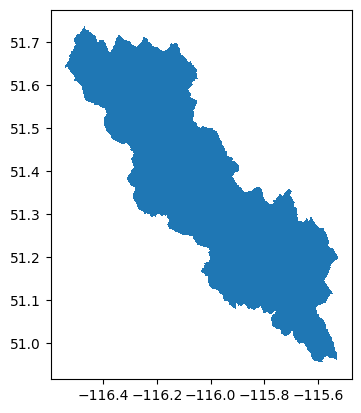

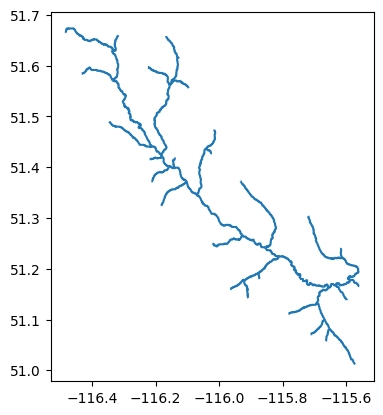

In [12]:
# plot
cat_up.plot()
riv_up.plot()
# save
cat_up.to_file(str(outdir_basin)+'/'+case_name+'_cat.shp')
riv_up.to_file(str(outdir_river)+'/'+case_name+'_riv.shp')

## Code provenance

In [13]:
# Generates a basic log file in the domain folder and copies the control file and itself there.
 
# Set the log path and file name
logPath = outdir_basin
log_suffix = '_basin_subset.txt'
 
# Create a log folder
logFolder = '_workflow_log'
Path( logPath / logFolder ).mkdir(parents=True, exist_ok=True)
 
# Copy this script
thisFile = 'basin_subset.ipynb'
copyfile(thisFile, logPath / logFolder / thisFile);
 
# Get current date and time
now = datetime.now()
 
# Create a log file
logFile = now.strftime('%Y%m%d') + log_suffix
with open( logPath / logFolder / logFile, 'w') as file:
     
    lines = ['Log generated by ' + thisFile + ' on ' + now.strftime('%Y/%m/%d %H:%M:%S') + '\n',
             'Generated basin subset .shp files from {} and {}.'.format(input_basin_name,input_river_name)]
    for txt in lines:
        file.write(txt)